In [ ]:
#To develop machine learning models
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.model_selection import GridSearchCV

#Vectorisation of database
from qdrant_client import QdrantClient

#Langchain framework to tune the OpenAI API to our documentation
import langchain
from langchain.llms import OpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

from dotenv import load_dotenv,find_dotenv

#To help maintain and manipulate json objects
import json

#To display the conversation between the user and chatbot
from IPython.display import display
import ipywidgets as widgets

#To manipulate the operating system
import os

#To ignore warnings
import warnings
warnings.filterwarnings("ignore")

Matplotlib is building the font cache; this may take a moment.


In [8]:
#Defining the OpenAPI Key
load_dotenv(find_dotenv())
OPENAI_API_KEY: str | None = os.getenv("OPEN_AI_API")
#Defining our LLM configuration 
llm = OpenAI(model_name = "gpt-3.5-turbo", temperature=0, max_tokens=2000, openai_api_key=OPENAI_API_KEY)

In [9]:
#Defining our vectorised dataset using QdrantClient

client = QdrantClient(":memory:")

def load_docs():
    directory = './Model_documents'
    for dirpath, dirnames, filenames in os.walk(directory):
        for filename in filenames:
            if filename.endswith('.txt'):
                with open(os.path.join(dirpath, filename), 'r', encoding='utf-8') as file:
                    documents = file.readlines()
                documents = [doc.strip() for doc in documents]
                client.add(collection_name="knowledge-base", documents=documents)
                
    return 1

In [10]:
#Function to automate model training and metrics generation
def runner(json_file, model_file):
    # Load parameters from JSON
    directory = './JSONs/'
    with open(directory+json_file, 'r') as file:
        parameters = json.load(file)
        
    with open(directory+model_file, 'r') as file:
        model_param = json.load(file)

    model_name = parameters['model_name']
    df = pd.read_csv("./datasets/" + str(parameters['filename']))
    flag = parameters['flag']

    #Check for target_variable is present or not
    target_variable = parameters.get("target_variable", None)
    if target_variable is None:
        raise ValueError("Target variable not specified in the parameters.")

    X = df.drop(columns=[target_variable])
    y = df[target_variable]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=parameters['split'], random_state=42)

    def_param = {
      "decision_tree" : {"param_dict" : "default_decision_tree_parameters", "lib_name" : "DecisionTreeClassifier"},
      "svm" : {"param_dict" : "default_svm_parameters", "lib_name" : "SVC"},
      "logistic_regression" : {"param_dict" : "default_lr_parameters", "lib_name" : "LogisticRegression"}
    }

    params= def_param[model_name]["param_dict"]
    param = model_param[params]
    lib_name = def_param[model_name]["lib_name"]
    
    #NO hyperparameter tuning
    if flag == 0:
      # Merge default and user-provided parameters
        merged_parameters = {**eval(str(param)), **parameters.get("param", {})}
      # print(merged_parameters)

      # Initialize machine learning model with the merged parameters
        model = eval(lib_name)(**merged_parameters)

      # Train the model
        model.fit(X_train, y_train)
        para = parameters.get("param", {})

      # Make predictions on the test set
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        cr = classification_report(y_test,y_pred)
        cm = confusion_matrix(y_test, y_pred)

        return_dict = {"acc" : acc, "cr" : cr, "cm" : cm ,"paramters" : str(para)}
        return return_dict
    
    #Hyperparameter tuning
    else:
        param_grid = parameters.get("param", {})
        grid_search = GridSearchCV(eval(lib_name)(), param_grid, cv=2, scoring='accuracy')

        # Fit the grid search to the data
        grid_search.fit(X_train, y_train)

        # Get the best parameters 
        best_params = grid_search.best_params_

        # Use the best parameters to train the final model
        final_model = grid_search.best_estimator_
        
        y_pred = final_model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        cr = classification_report(y_test,y_pred)
        cm = confusion_matrix(y_test, y_pred)

        return_dict = {"acc" : acc, "cr" : cr, "cm" : cm ,"paramters" : str(best_params)}
        return return_dict

In [11]:
#Function to stip json file of excess garbage string values
def parse_json_garbage(s):
    start_idx = next(idx for idx, c in enumerate(s) if c in "{[")
    s = s[start_idx:]
    try:
        return json.loads(s)
    except json.JSONDecodeError as e:
        return json.loads(s[:e.pos])

In [12]:
#Define prompt template using langchain
def rag(chat_history: list[str], question: str, n_points: int = 3) -> str:
    results = client.query(
        collection_name="knowledge-base",
        query_text=question,
        limit=n_points,
    )
    
    context = "\n".join(r.document for r in results)
    context = context.strip()
    
    # Define the prompt template with input variables
    prompt_template = PromptTemplate(
        input_variables=["question", "chat_history", "context"],
        template="""
    You are a helpful machine learning bot.
    Answer the following question using the provided context.
    In the beginning of the conversation user will specify which model it wants to use. return 1 when this kind of query is specified. if the model name is not specified in the beginning ask the user and then return 1. 
    If the user asks you to build a model : If the parameters are not defined by the user, ask them to specify, a sample json file that is to be to made to run
    the model looks like this:
    [
    "filename" : "<filename>.csv",
    "model_name" : "<model_name>",
    "param": [
        "<param name>": "<value>"
    ],
    "target_variable": "<target_name>",
    "split" : 0.2,
    "flag" : 0/1
    ] 
    
    Please note that "flag" must be 0 by default, unless the user wants to perform "hyperparameter tuning" or when the user provides multiple values for some parameters (i.e, when values > 1 for a parameter), only then must be changed to 1.
    Also keep in mind that if the user wants to do hyperparameter tuning, i.e., flag = 1; store all the values for a parameter in a python list [], for example:
    
    "param": [
        "<param name>": [<value1>, <value2>, <value3>]
    ]
    
    This is not the default json. this is just a format, change all the names here according to the latest chat. replace [] with curly brackets.
    if everything is mentioned return the json file
    if user says build or run or train the model or something of that sort stating to run the given json, return -1
    if the user asks for decision tree as model name input in the json file as "decsion_tree"
    if the user asks for lr as model name input it in the json file as "logistic_regression"
    if the user asks for support vector machine as model name  in the the input,portray it in the json file as "svm"
    Always make sure you are checking this first before giving any response. 
    Also refer to the chat history while answering a question. consider info given by the assisstant only as truth.
    The user could ask you two types of questions - one regarding the machine learning parameters and their acceptable values or anything related to the architecture of the machine learning model. The other set of the questions would be related to creating a json file for given parameter values and when user asks you to run the model. When asked direct questions about json building and model running remember answers in the chat history and when asked factual question about the model architecture refer to the context documentation. 
    If you have limited information on something, state is and then answer "this is all I know." irrespective of how much their word count expectation is.
    Also keep in mind that the user can specify multiple model configurations and ask you to store those model parameters and their performance. 
    For example, a user may say that “design model 1 for decision tree with criterion = entropy, max_depth = 10”, after evaluating performance of model 1 it may provide new parameters like “design model 2 for decision tree with criterion = mini, max_depth = 5”. In such a case, the user may ask you to compare model 1 and model 2 performances which you must do. 
    

    Question: {question}
    CHAT HISTORY : {chat_history}
    Context: {context}

    Answer:
    """
    )

    # Create the Langchain instance
    chain = LLMChain(llm=llm, prompt=prompt_template)
    
    response = chain.run(question=question, chat_history=chat_history, context = context)
    return response


In [ ]:
chat_history = []

def on_submit(_):
    query = input_box.value # type: ignore

    if query.lower() == 'exit':
        print("Thank you for using the State of the Union chatbot!")
        return 
    
    #To load model documentation
    if len(chat_history) == 0:
        display(widgets.HTML(f'<b><font color="blue">Chatbot:</font></b> Loading the model documentation please wait...'))
        chat_history.append((query, "done"))
        load_docs()
        display(widgets.HTML(f'<b><font color="blue">Chatbot:</font></b> Machine Learning models documentation loaded into memory!'))
    
    #To answer the queries made by the user
    elif len(chat_history) != 0:
        response = rag(chat_history, query)
        result = response
        
        if result == '-1':
            display(widgets.HTML(f'<b>User:</b> {query}'))
            display(widgets.HTML(f'<b><font color="blue">Chatbot:</font></b> Building model please wait...'))
            chat_history.append((query, 'building model please wait'))
            data_dict = parse_json_garbage(chat_history[-2][-1])
            print(data_dict)
            json_file_path = "./JSONs/sample.json"
            with open(json_file_path, 'w') as json_file:
                json.dump(data_dict, json_file,indent=2)
            result = runner("sample.json","model_parameters.json")
            acc = result['acc']
            cr = result['cr']
            cm = result['cm']
            bp = result['paramters']
        
            result = 'The following are the model params and evaluation metrics ' + str(result)
        
            chat_history.append((query, result))
            display(widgets.HTML(f'<b><font color="blue">Chatbot:</font></b> The parameters used are: {bp}'))
            display(widgets.HTML(f'<b><font color="blue">Chatbot:</font></b> The accuracy of the model is {acc}'))
        
            display(widgets.HTML(f'<b><font color="blue">Chatbot:</font></b> The classification report of the model is {cr}'))
            display(widgets.HTML(f'<b><font color="blue">Chatbot:</font></b> The confusion matrix of the model is {sns.heatmap(cm, annot=True)}'))

        else:
            chat_history.append((query, result))
            display(widgets.HTML(f'<b>User:</b> {query}'))
            display(widgets.HTML(f'<b><font color="blue">Chatbot:</font></b> {result}'))
    
    input_box.value = "" # type: ignore

Welcome to the Transformers chatbot! Type done when you want run the model. Type 'exit' to stop.


Text(value='', placeholder='Please enter your question:')

HTML(value='<b><font color="blue">Chatbot:</font></b> Loading the model documentation please wait...')

HTML(value='<b><font color="blue">Chatbot:</font></b> Machine Learning models documentation loaded into memory…

HTML(value='<b>User:</b> what are the parameters of svm?')

HTML(value='<b><font color="blue">Chatbot:</font></b> The parameters of SVM (Support Vector Machine) in sklear…

HTML(value='<b>User:</b> ')

HTML(value='<b><font color="blue">Chatbot:</font></b> 1')

HTML(value='<b>User:</b> train an svm model on churn.csv model with C=10, kernel = linear and target_variable …

HTML(value='<b><font color="blue">Chatbot:</font></b> {\n    "filename": "churn.csv",\n    "model_name": "svm"…

HTML(value='<b>User:</b> change split to 0.4')

HTML(value='<b><font color="blue">Chatbot:</font></b> {\n    "filename": "churn.csv",\n    "model_name": "svm"…

HTML(value='<b>User:</b> train model')

HTML(value='<b><font color="blue">Chatbot:</font></b> Building model please wait...')

HTML(value='<b><font color="blue">Chatbot:</font></b> The parameters used are: {\'C\': 10, \'kernel\': \'linea…

HTML(value='<b><font color="blue">Chatbot:</font></b> The accuracy of the model is 0.7975')

HTML(value='<b><font color="blue">Chatbot:</font></b> The classification report of the model is               …

HTML(value='<b><font color="blue">Chatbot:</font></b> The confusion matrix of the model is Axes(0.125,0.11;0.6…

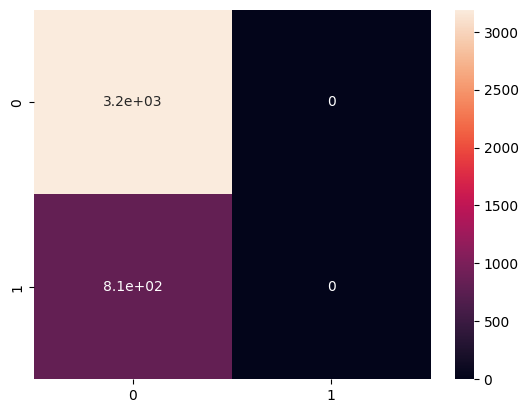

In [ ]:
print("Welcome to the Transformers chatbot! Type done when you want run the model. Type 'exit' to stop.")

input_box = widgets.Text(placeholder='Please enter your question:')
input_box.on_submit(on_submit)

display(input_box)

In [16]:
chat_history

[('what is svm parameters?', 'done'),
 ('what are the parameters of svm?',
  'The parameters of SVM (Support Vector Machine) in sklearn are:\n- C\n- kernel\n- degree\n- gamma\n- coef0\n- shrinking\n- probability\n- tol\n- cache_size\n- class_weight\n- verbose\n- max_iter\n- decision_function_shape\n- break_ties\n- random_state\n\nIf you need more specific details on any of these parameters, feel free to ask!'),
 ('', '1'),
 ('train an svm model on churn.csv model with C=10, kernel = linear and target_variable = Exited',
  '{\n    "filename": "churn.csv",\n    "model_name": "svm",\n    "param": {\n        "C": 10,\n        "kernel": "linear"\n    },\n    "target_variable": "Exited",\n    "split": 0.2,\n    "flag": 0\n}'),
 ('change split to 0.4',
  '{\n    "filename": "churn.csv",\n    "model_name": "svm",\n    "param": {\n        "C": 10,\n        "kernel": "linear"\n    },\n    "target_variable": "Exited",\n    "split": 0.4,\n    "flag": 0\n}'),
 ('train model', 'building model please